# Deep Globe Road Extraction - EDA



**1. Introduction:**

In disaster zones, especially in developing countries, maps and accessibility information are crucial for crisis response.DeepGlobeRoad Extraction Challenge poses the challenge of automatically extracting roads and street networks from satellite images.

**2. Business problem:**

It is basically a computer vision based deep learning problem. Using satellite images provided in the dataset and the state of the art segmentation based algorithms weshould be able to extract the road from the satellite images.

**3. Mapping the Business problem to Deep learning:**

It is Computer vision based Semantic segmentation problem. Here we have 2 classes one is road and remaining objects in image will be other than road like buildings , grass etc. It is binary image segmentation task.

**4. Data set analysis:**

We have total of 14796 satellite and mask images
* Training satellite images - 6226
* Training mask images - 6226
* Validation satellite images - 1243
* Test satellite images - 1101



We need to predict mask images for validation and test image datasets.

Kaggle data source link - https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset?select=class_dict.csv2

**5. Performance metric:Intersection over union (IOU):**

 * The Intersection-Over-Union (IoU), also known as the Jaccard Index, is one ofthe most commonly used metrics in semantic segmentation. The IoU is a verystraightforward metric that’s extremely effective.

 * IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth

In [ ]:
#import libraries
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
# Extract all the archived files
zf = ZipFile("/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/archive.zip","r")
zf.extractall()

# 1. compute the train,valid and test file sizes

In [ ]:
train_list = os.listdir('train')
valid_list = os.listdir('valid')
test_list = os.listdir('test')

train_size = 0
valid_size = 0
test_size = 0

for each in train_list:
  file_size = os.path.getsize('/content/train/'+each)
  train_size = train_size + file_size

for each in valid_list:
  file_size = os.path.getsize('/content/valid/'+each)
  valid_size = valid_size + file_size

for each in test_list:
  file_size = os.path.getsize('/content/test/'+each)
  test_size = test_size + file_size

In [ ]:
print('train-size : '+str(train_size/(10**9))+' GB')
print('valid-size : '+str(valid_size/(10**9))+' GB')
print('test-size : '+str(test_size/(10**9))+' GB')
print('-'*50)
print('Total-size : '+str((train_size+test_size+valid_size)/(10**9))+' GB')

train-size : 3.005402694 GB
valid-size : 0.578836736 GB
test-size : 0.536324423 GB
--------------------------------------------------
Total-size : 4.120563853 GB


In [ ]:
font = {'color':'black','weight':'bold','size':20}
tick_color = '#104E8B'

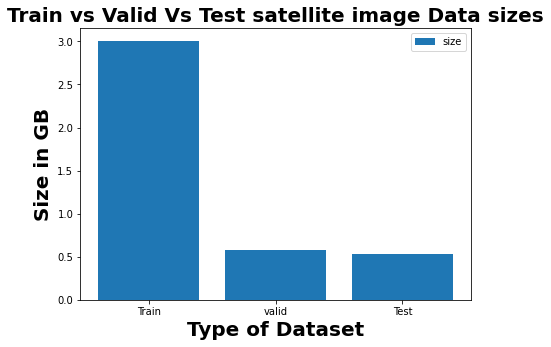

In [ ]:
#barplot of train,valid,test datasets
x = np.array(["Train", "valid", "Test"])
y = np.array([train_size/10**9, valid_size/10**9, test_size/10**9])
plt.figure(figsize=(7,5))
plt.bar(x, y)
plt.title('Train vs Valid Vs Test satellite image Data sizes',fontdict=font)
plt.xlabel('Type of Dataset',fontdict=font)
plt.ylabel('Size in GB',fontdict=font)
plt.legend(['size'])
plt.show()

# 2. compute the count of train,valid and test satellige images and mask images

In [ ]:
df = pd.read_csv('/content/metadata.csv')
df

image_id  split        sat_image_path              mask_path
0       100034  train  train/100034_sat.jpg  train/100034_mask.png
1       100081  train  train/100081_sat.jpg  train/100081_mask.png
2       100129  train  train/100129_sat.jpg  train/100129_mask.png
3       100703  train  train/100703_sat.jpg  train/100703_mask.png
4       100712  train  train/100712_sat.jpg  train/100712_mask.png
...        ...    ...                   ...                    ...
8565    998829   test   test/998829_sat.jpg                    NaN
8566    998928   test   test/998928_sat.jpg                    NaN
8567    999518   test   test/999518_sat.jpg                    NaN
8568    999651   test   test/999651_sat.jpg                    NaN
8569    999703   test   test/999703_sat.jpg                    NaN

[8570 rows x 4 columns]

In [ ]:
df.isnull().sum()

image_id             0
split                0
sat_image_path       0
mask_path         2344
dtype: int64

In [ ]:
train_normal_image_count = df[df['split']=='train']['sat_image_path'].notnull().sum()
train_mask_image_count = df[df['split']=='train']['mask_path'].notnull().sum()

valid_normal_image_count = df[df['split']=='valid']['sat_image_path'].notnull().sum()
valid_mask_image_count = df[df['split']=='valid']['mask_path'].notnull().sum()

test_normal_image_count = df[df['split']=='test']['sat_image_path'].notnull().sum()
test_mask_image_count = df[df['split']=='test']['mask_path'].notnull().sum()

In [ ]:
print('count of train normal images : '+str(train_normal_image_count))
print('count of train mask images : '+str(train_mask_image_count))
print('count of vaid normal images : '+str(valid_normal_image_count))
print('count of valid mask images : '+str(valid_mask_image_count))
print('count of test normal images : '+str(test_normal_image_count))
print('count of test mask images : '+str(test_mask_image_count))
print('-'*50)
print('count of Total images : '+str(len(train_list)+len(valid_list)+len(test_list)))

count of train normal images : 6226
count of train mask images : 6226
count of vaid normal images : 1243
count of valid mask images : 0
count of test normal images : 1101
count of test mask images : 0
--------------------------------------------------
count of Total images : 14796


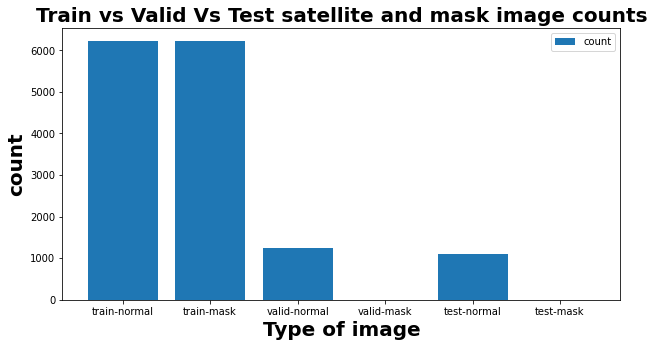

In [ ]:
#barplot of the count of train,valid,test normal and mask images
x = np.array(["train-normal", "train-mask", "valid-normal", "valid-mask","test-normal","test-mask"])
y = np.array([train_normal_image_count,train_mask_image_count,valid_normal_image_count,valid_mask_image_count,test_normal_image_count,test_mask_image_count])
plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Train vs Valid Vs Test satellite and mask image counts',fontdict=font)
plt.xlabel('Type of image',fontdict=font)
plt.ylabel('count',fontdict=font)
plt.legend(['count'])
plt.show()

# 3. Display satellite and mask images

In [ ]:
def display_images(split):

  if split == 'train':
    #get 5 train image paths from dataframe df
    display_df = df[df['split'] == split][:5]
    
    #get normal satellite and mask image paths
    sat_images_path = [path for path in display_df['sat_image_path'].to_list()]
    mask_images_path = [path for path in display_df['mask_path'].to_list()]
    
    #get normal satellite and mask image titles
    sat_titles = [path.split('/')[-1] for path in sat_images_path]
    mask_titles = [path.split('/')[-1] for path in mask_images_path]
    
    for i in range(len(display_df)):
      
      #read normal satellite image
      sat_image_BGR = cv.imread(sat_images_path[i])
      sat_image_RGB = cv.cvtColor(sat_image_BGR, cv.COLOR_BGR2RGB)
      
      #read masked image
      mask_image = cv.imread(mask_images_path[i], cv.IMREAD_UNCHANGED)
      
      #plot the satellite and mask image
      plt.figure(figsize=(10, 10))
      plt.subplot(1, 2, 1)
      plt.title(sat_titles[i])
      plt.imshow(sat_image_RGB)

      plt.subplot(1, 2, 2)
      plt.title(mask_titles[i])
      plt.imshow(mask_image)
      plt.show()

  if split == 'valid' or split == 'test':
     #get 5 valid or test image paths from dataframe df
    display_df = df[df['split'] == split][:5]
    
    #get normal satellite image paths
    sat_images_path = [path for path in display_df['sat_image_path'].to_list()]
    
    #get normal satellite image titles
    sat_titles = [path.split('/')[-1] for path in sat_images_path]
    
    for i in range(len(display_df)):
      
      #read normal satellite image
      sat_image_BGR = cv.imread(sat_images_path[i])
      sat_image_RGB = cv.cvtColor(sat_image_BGR, cv.COLOR_BGR2RGB)
      
      #plot the normal satellite image
      plt.figure(figsize=(5, 5))
      plt.title(sat_titles[i])
      plt.imshow(sat_image_RGB)


## 3.1 train dataset satellite and mask images

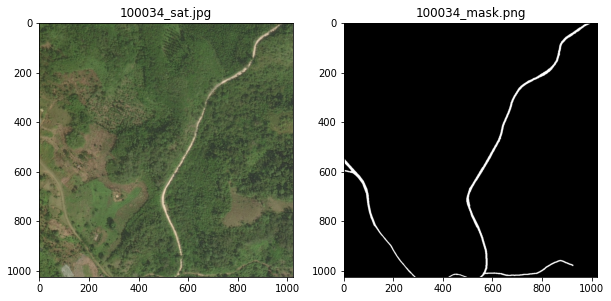

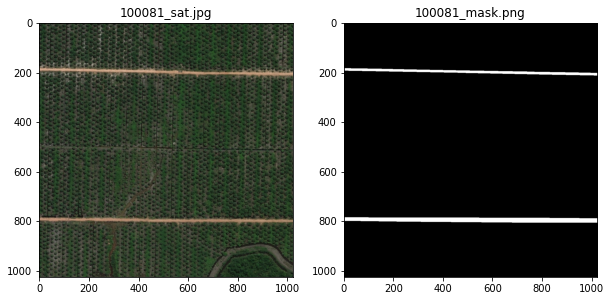

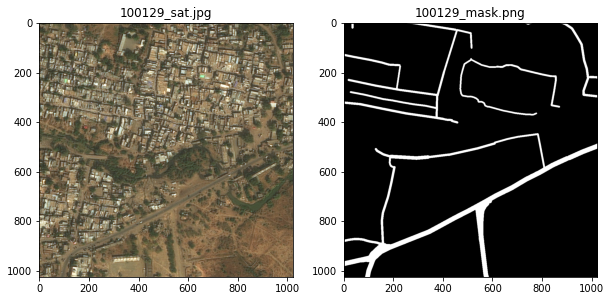

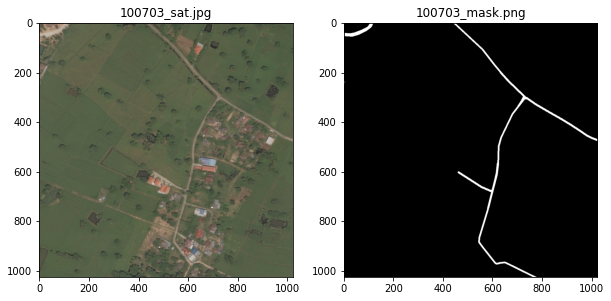

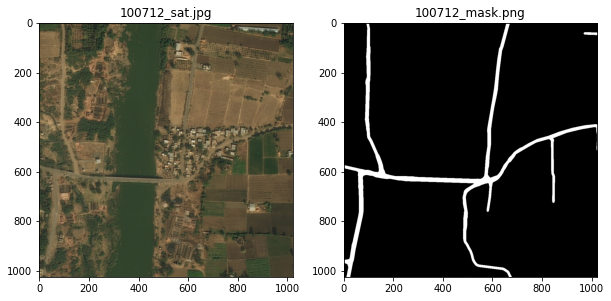

In [ ]:
display_images(split = 'train')

## 3.2 valid dataset satellite images

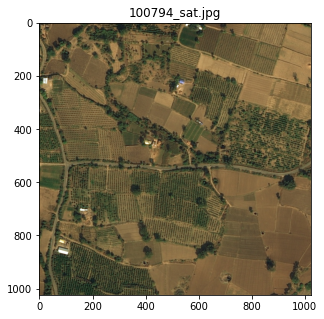

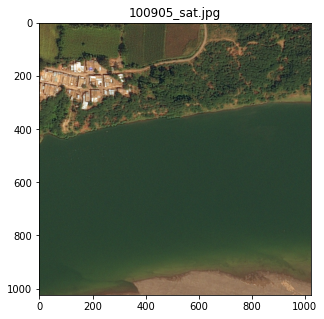

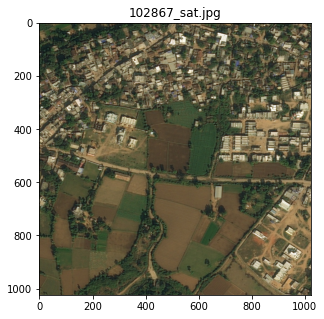

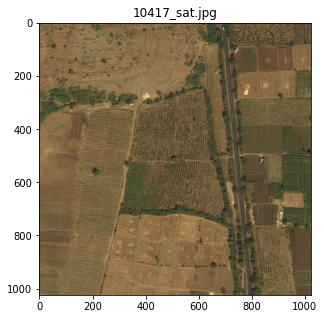

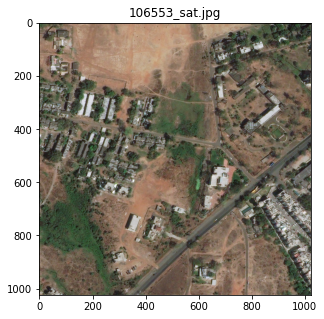

In [ ]:
display_images(split = 'valid')

## 3.3 test dataset satellite images

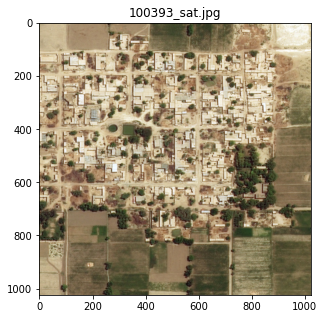

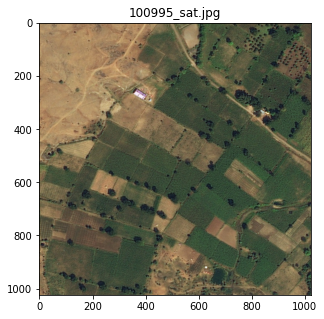

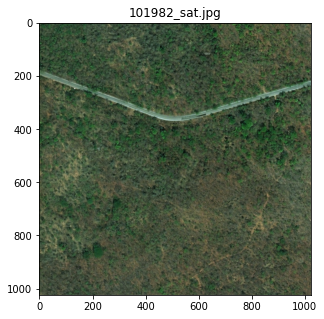

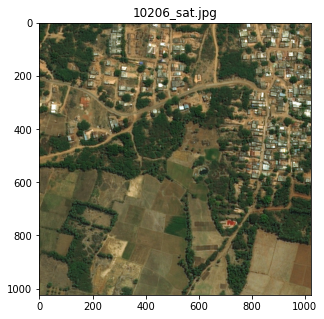

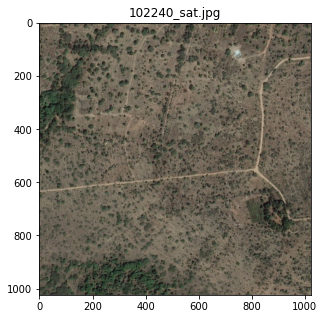

In [ ]:
display_images(split = 'test')

# 4. Binarize images if required

In [ ]:
pd.read_csv('class_dict.csv')

name    r    g    b
0        road  255  255  255
1  background    0    0    0

In [ ]:
def ispure():
  train_mask_paths = df[df['split'] == 'train']['mask_path']
  for each in tqdm(train_mask_paths):
    img = cv.imread('train/100034_mask.png',cv.IMREAD_UNCHANGED)
    pure = np.all((img==0) | (img==255))
    if pure == False:
      break
  return pure

In [ ]:
pure = ispure()

if pure == False:
  print('\nBack ground values are not pure 0 and 255. Binarization process is required')
else:
  print('\nBack ground values are pure 0 and 255. Binarization process is not required')

100%|██████████| 6226/6226 [01:23<00:00, 74.58it/s]


Back ground values are pure 0 and 255. Binarization process is not required


# 5. Resize the images

In [ ]:
def resize_images(split , size, rootfolder):

  if split == 'train':
    #get train image paths from dataframe df
    display_df = df[df['split'] == split]
    
    #get normal satellite and mask image paths
    sat_images_path = [path for path in display_df['sat_image_path'].to_list()]
    mask_images_path = [path for path in display_df['mask_path'].to_list()]
    
    #get normal satellite and mask image titles
    sat_titles = [path.split('/')[-1] for path in sat_images_path]
    mask_titles = [path.split('/')[-1] for path in mask_images_path]
    
    for i in tqdm(range(len(display_df))):
      
      #read and resize normal satellite image
      sat_image = cv.imread(sat_images_path[i])
      sat_image_resize = cv.resize(sat_image, (size, size), interpolation=cv.INTER_NEAREST)
      
      #read and resize masked image
      mask_image = cv.imread(mask_images_path[i], cv.IMREAD_UNCHANGED)
      mask_image_resize = cv.resize(mask_image, (size, size), interpolation=cv.INTER_NEAREST)
      
      #save resize images
      cv.imwrite(rootfolder + '/train/' + sat_titles[i], sat_image_resize)
      cv.imwrite(rootfolder + '/train/' + mask_titles[i], mask_image_resize)


  if split == 'valid' or split == 'test':
    #get valid or test image paths from dataframe df
    display_df = df[df['split'] == split]
    
    #get normal satellite image paths
    sat_images_path = [path for path in display_df['sat_image_path'].to_list()]
    
    #get normal satellite image titles
    sat_titles = [path.split('/')[-1] for path in sat_images_path]
    
    for i in tqdm(range(len(display_df))):
      
      #read normal satellite image
      sat_image = cv.imread(sat_images_path[i])
      sat_image_resize = cv.resize(sat_image, (size, size), interpolation=cv.INTER_NEAREST)
      
      #save resize images
      cv.imwrite(rootfolder + '/'+ split +'/' + sat_titles[i], sat_image_resize)


## 5.1 resize the train dataset images



In [ ]:
resize_images(split='train', size=256, rootfolder = 'ResizeArchive')

100%|██████████| 6226/6226 [04:00<00:00, 25.91it/s]


## 5.2 resize the valid dataset images

In [ ]:
resize_images(split='valid', size=256, rootfolder = 'ResizeArchive')

100%|██████████| 1243/1243 [00:33<00:00, 36.77it/s]


## 5.3 resize the test dataset images

In [ ]:
resize_images(split='test', size=256, rootfolder = 'ResizeArchive')

100%|██████████| 1101/1101 [00:29<00:00, 37.40it/s]


# 6. saving resized images into gdrive

In [ ]:
#import shutil
#shutil.make_archive('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/ResizeArchive', 'zip', '/content/ResizeArchive/')

'/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/ResizeArchive.zip'

In [ ]:
# Extract all the resized archived files
ra = ZipFile("/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/ResizeArchive.zip","r")
ra.extractall()

# 7. Display Resized images

### 7.1 train dataset satellite and mask images

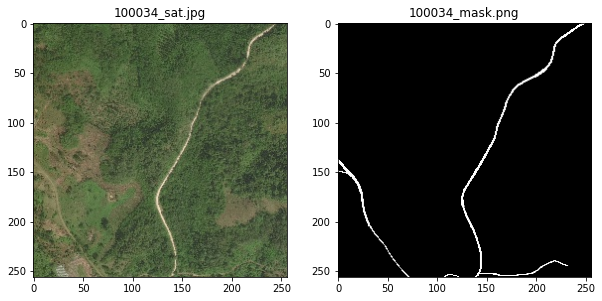

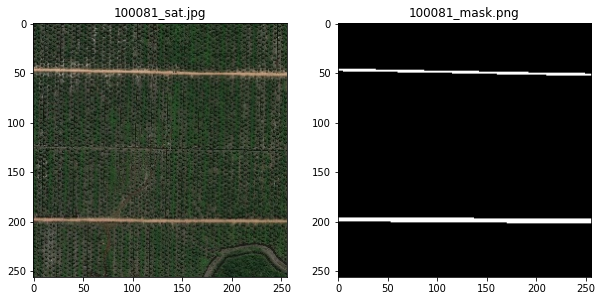

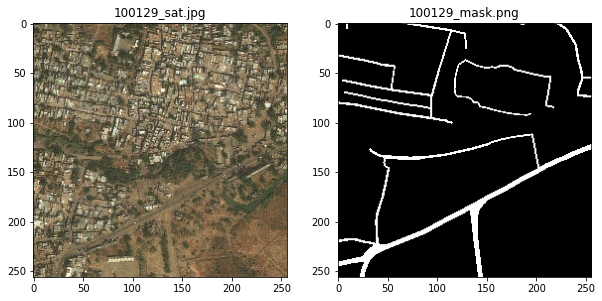

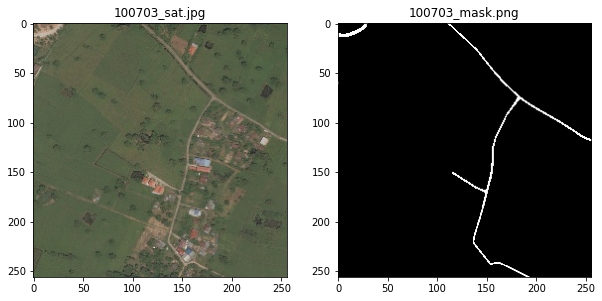

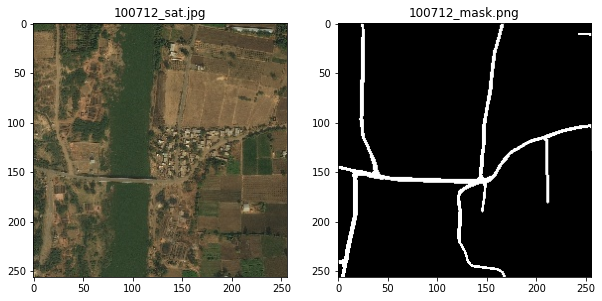

In [ ]:
display_images(split = 'train')

### 7.2 valid dataset satellite images

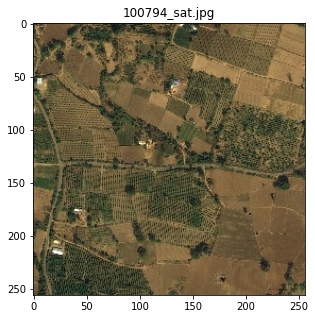

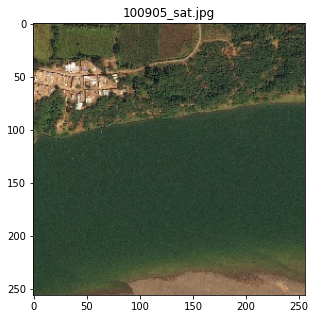

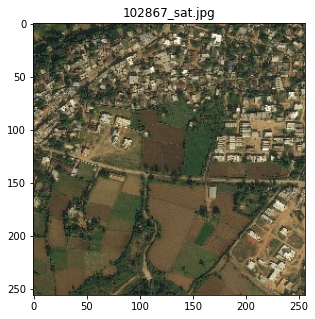

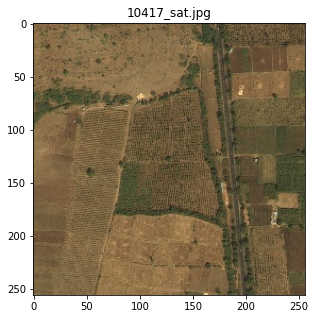

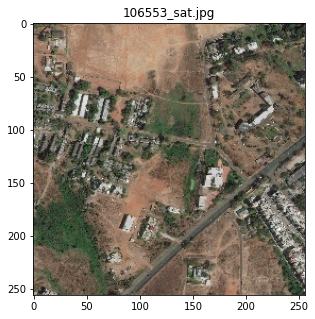

In [ ]:
display_images(split = 'valid')

### 7.3 test dataset satellite images

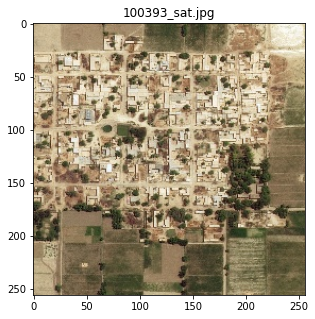

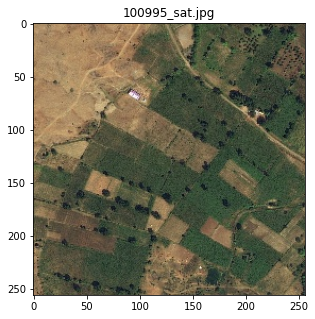

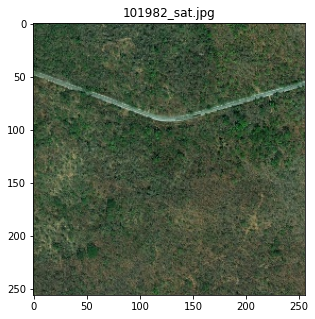

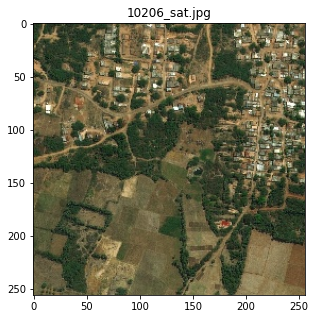

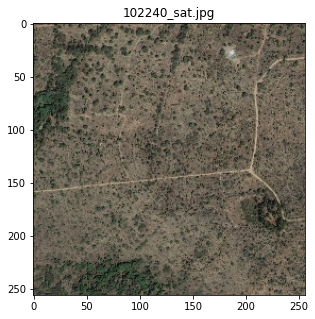

In [ ]:
display_images(split = 'test')

# 8. conclusions

*   The kaggle dataset consists of three image dataset folders train,valid,test and two csv files one is class_dict.csv which contains data regarding the pixel values of road and background with 0 and 255 values respectively and other is metadata.csv which contains the satellite image and mask image datapaths of train, valid and test datasets.

* Analysed the datasizes of train, valid and test datsets . Total size is 4.12 GB which comprises of:

    * train - 3.00 GB
    * valid - 0.58 GB
    * test -  0.54 GB
* Analysed the count of satellite and mask images for all the datasets.We have total of 14796 satellite and mask images
  * Training satellite images - 6226
  * Training mask images - 6226
  * Validation satellite images - 1243
  * Test satellite images - 1101

* Displayed the train satellite and mask images , valid satellite images and test satellite images

* Analysed all the pixel values of all the masked images to check whether they are pure 0 and 255 or not. All the pixel values are pure 0 and 255 so binarization process is  not required.

* Resizing the image size from 1024 to 256 which helps in faster training process. so, here we resized all the train satellite and mask images , valid images , test images

* Displayed all the resized train satellite and mask images , valid satellite images and test satellite images to confirm whether they remain intact after resizing or not.



In [ ]:
# Extract all the resized archived files
ra = ZipFile("/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/ResizeArchive.zip","r")
ra.extractall()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/metadata.csv')
df.head()

image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png

In [ ]:
simage = cv.imread('train/100034_sat.jpg')
simage = cv.resize(simage,(128,128),interpolation=cv.INTER_NEAREST)
simage[:,:,0].shape

(128, 128)

In [ ]:
import imgaug.augmenters as iaa
iaa.Fliplr(1).augment_image(simage==55)

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [ True, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,